<a href="https://colab.research.google.com/github/sayakpaul/Image-Adversaries-101/blob/master/Adversarial_Training_NSL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, we are going to:
- Train an image classification model to classify different flower species.
- Create adversarial examples to launch targeted attcks to the classifier.
- Train an adversarially robust classifier using [`Neural Structured Learning`](https://www.tensorflow.org/neural_structured_learning).

We are primarily going to use TensorFlow for this.

## Training an image classification model to classify different flower species

In [0]:
!pip install tensorflow-gpu==2.2.0-rc2

In [2]:
# TensorFlow version
import tensorflow as tf
print(tf.__version__)

2.2.0-rc2


In [3]:
# Which GPU?
!nvidia-smi

Tue Apr 28 05:56:24 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
# other imports
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from imutils import paths
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import random
import shutil
import time
import cv2
import os

In [5]:
# Gather Flowers-17 dataset
data_root = tf.keras.utils.get_file(
  "/content/flower_photos", "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz",
   untar=True)

228818944/228813984 [==============================] - 3s 0us/step


In [0]:
# Untar the dataset
!tar -xvf flower_photos.tar.gz

In [0]:
# tree for viewing directory structures
!sudo apt-get install tree

In [8]:
!tree --dirsfirst --filelimit 10 flower_photos

flower_photos
├── daisy [633 entries exceeds filelimit, not opening dir]
├── dandelion [898 entries exceeds filelimit, not opening dir]
├── roses [641 entries exceeds filelimit, not opening dir]
├── sunflowers [699 entries exceeds filelimit, not opening dir]
├── tulips [799 entries exceeds filelimit, not opening dir]
└── LICENSE.txt

5 directories, 1 file


In [9]:
# All the paths of the flowers
ALL_IMG_PATHS = list(paths.list_images("flower_photos"))
print(ALL_IMG_PATHS[:10])

['flower_photos/dandelion/5217892384_3edce91761_m.jpg', 'flower_photos/dandelion/14053173516_a00150a919_m.jpg', 'flower_photos/dandelion/2535727910_769c020c0d_n.jpg', 'flower_photos/dandelion/4573204407_babff0dce4_n.jpg', 'flower_photos/dandelion/7295618968_c08a326cc1_m.jpg', 'flower_photos/dandelion/18479635994_83f93f4120.jpg', 'flower_photos/dandelion/16970837587_4a9d8500d7.jpg', 'flower_photos/dandelion/19443726008_8c9c68efa7_m.jpg', 'flower_photos/dandelion/18238604119_a5689980ee_n.jpg', 'flower_photos/dandelion/5605502523_05acb00ae7_n.jpg']


In [10]:
# shuffle the image paths and preview
random.shuffle(ALL_IMG_PATHS)
ALL_IMG_PATHS[:5]

['flower_photos/dandelion/2453532367_fc373df4de.jpg',
 'flower_photos/roses/15901230359_1819e96b89_n.jpg',
 'flower_photos/daisy/2641151167_3bf1349606_m.jpg',
 'flower_photos/tulips/402525114_eaa60c8341_m.jpg',
 'flower_photos/sunflowers/857698097_8068a2c135_n.jpg']

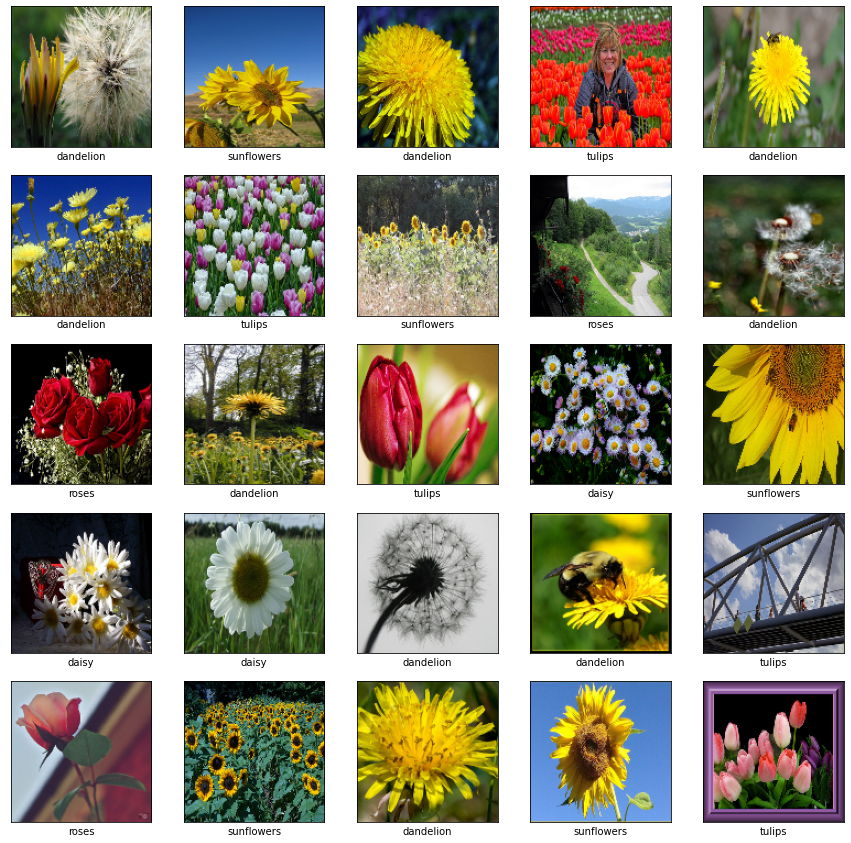

In [11]:
# Visualize images
plt.figure(figsize=(15,15))
for i in range(25):
    image_path = np.random.choice(ALL_IMG_PATHS)
    image = plt.imread(image_path)
    image = cv2.resize(image, (128, 128))
    # you might want to verify the labels before 
    # you put this to use
    label = image_path.split("/")[1]
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(True)
    plt.imshow(image)
    plt.xlabel(label)
plt.show()

In [0]:
# split image paths into test and train splits
testImgs = int(len(ALL_IMG_PATHS) * 0.15)
trainImgs = len(ALL_IMG_PATHS) - testImgs
trainImgPaths = ALL_IMG_PATHS[:trainImgs]
testImgPaths = ALL_IMG_PATHS[trainImgs:]

In [0]:
# specify the directory paths
train_dir = "train"
val_dir = "val"

In [0]:
def move_images(imgPaths, outputDir):
	# iterate through the image paths
	for imagePath in imgPaths:
		# extract the label from the current image path
		label = imagePath.split("/")[1]

		# check if a directory for the label exists, if not, create it
		imageDir = os.path.join(outputDir, label)
		if not os.path.exists(imageDir):
			os.makedirs(imageDir)

		# copy the current image to the respective folder
		shutil.copy2(imagePath, imageDir)

In [0]:
move_images(trainImgPaths, train_dir)
move_images(testImgPaths, val_dir)

In [18]:
# Verify structures
!tree --dirsfirst --filelimit 10 train
!tree --dirsfirst --filelimit 10 val

train
├── daisy [535 entries exceeds filelimit, not opening dir]
├── dandelion [760 entries exceeds filelimit, not opening dir]
├── roses [551 entries exceeds filelimit, not opening dir]
├── sunflowers [590 entries exceeds filelimit, not opening dir]
└── tulips [684 entries exceeds filelimit, not opening dir]

5 directories, 0 files
val
├── daisy [98 entries exceeds filelimit, not opening dir]
├── dandelion [138 entries exceeds filelimit, not opening dir]
├── roses [90 entries exceeds filelimit, not opening dir]
├── sunflowers [109 entries exceeds filelimit, not opening dir]
└── tulips [115 entries exceeds filelimit, not opening dir]

5 directories, 0 files


In [19]:
# Setup data generators
train_aug = ImageDataGenerator(rescale=1/255.)
val_aug = ImageDataGenerator(rescale=1/255.)

train_gen = train_aug.flow_from_directory("train",
    class_mode="categorical",
    target_size=(224, 224),
	color_mode="rgb",
	shuffle=True,
	batch_size=32
)
val_gen = train_aug.flow_from_directory("val",
    class_mode="categorical",
    target_size=(224, 224),
	color_mode="rgb",
	shuffle=False,
	batch_size=32
)

Found 3120 images belonging to 5 classes.
Found 550 images belonging to 5 classes.


In [20]:
# Load the MobileNetV2 model but exclude the classification layers
EXTRACTOR = MobileNetV2(weights="imagenet", include_top=False,
                    input_shape=(224, 224, 3))

9412608/9406464 [==============================] - 0s 0us/step


In [0]:
def get_training_model():
    # We are not training the extractor model
    EXTRACTOR.trainable = False
    # Construct the head of the model that will be placed on top of the
    # the base model
    class_head = EXTRACTOR.output
    class_head = GlobalAveragePooling2D()(class_head)
    class_head = Dense(512, activation="relu")(class_head)
    class_head = Dropout(0.5)(class_head)
    class_head = Dense(5, activation="softmax")(class_head)

    # Create the new model
    classifier = Model(inputs=EXTRACTOR.input, outputs=class_head)

    # Compile and return the model
    classifier.compile(loss="categorical_crossentropy", 
                          optimizer="adam",
                          metrics=["accuracy"])

    return classifier

In [22]:
# Train the model
start = time.time()
flower_model = get_training_model()
h = flower_model.fit(train_gen,
              steps_per_epoch=3120//32,
              validation_data=val_gen,
              validation_steps=550//32,
              epochs=10)
print("Total training time: ",time.time()-start)

Epoch 1/10
97/97 [==============================] - 15s 150ms/step - loss: 0.6071 - accuracy: 0.7880 - val_loss: 0.3241 - val_accuracy: 0.8860
Epoch 2/10
97/97 [==============================] - 13s 139ms/step - loss: 0.3204 - accuracy: 0.8786 - val_loss: 0.3774 - val_accuracy: 0.8658
Epoch 3/10
97/97 [==============================] - 14s 139ms/step - loss: 0.2551 - accuracy: 0.9077 - val_loss: 0.3074 - val_accuracy: 0.8805
Epoch 4/10
97/97 [==============================] - 13s 137ms/step - loss: 0.1834 - accuracy: 0.9365 - val_loss: 0.3230 - val_accuracy: 0.8971
Epoch 5/10
97/97 [==============================] - 13s 136ms/step - loss: 0.1583 - accuracy: 0.9475 - val_loss: 0.3159 - val_accuracy: 0.8934
Epoch 6/10
97/97 [==============================] - 13s 137ms/step - loss: 0.1213 - accuracy: 0.9576 - val_loss: 0.3182 - val_accuracy: 0.9062
Epoch 7/10
97/97 [==============================] - 13s 136ms/step - loss: 0.0882 - accuracy: 0.9696 - val_loss: 0.3158 - val_accuracy: 0.9044

In [0]:
# Specify the class labels, we would need this to create targeted attacks
CLASSES = ["daisy", "dandelion", "roses", "sunflowers", "tulips"]

In [24]:
# Let's take an image from the validation set randomly
all_val_imgs = list(paths.list_images("val"))
sample_val_image = np.random.choice(all_val_imgs, 1)[0]
sample_val_image

'val/tulips/3991742794_edebc6c8a0_n.jpg'

In [0]:
# A utility function for sample predictions
def generate_predictions(model, image_path):
    # Prepare the image for prediction-ready
    original_label = image_path.split("/")[1]
    image_pixels = plt.imread(image_path)
    image_pixels = cv2.resize(image_pixels, (224, 224))
    image_pixels = image_pixels/255.
    image_pixels = np.expand_dims(image_pixels, axis=0)

    # Generate predictions
    preds = model.predict(image_pixels)[0]
    i = np.argmax(preds)
    pred_label = CLASSES[i]

    print("Original label: {} predicted label: {}".format(original_label, pred_label))

    return preds

In [26]:
# Let's see
preds = generate_predictions(flower_model, sample_val_image)

Original label: tulips predicted label: tulips


## Creating adversarial examples to fool the above image classifier

In [27]:
# Loss has to be very low here
cce = tf.keras.losses.SparseCategoricalCrossentropy()
loss = cce(
    tf.convert_to_tensor([CLASSES.index(sample_val_image.split("/")[1])]),
    tf.convert_to_tensor(preds)
)
print(loss.numpy())

# The probability we got when we ran the inference
print(np.exp(-loss.numpy()))

0.00014149141
0.9998585


In [0]:
# We won't need normalization for now
def preprocess_image_without(image_path):
    image_pixels = plt.imread(image_path)
    image_pixels = cv2.resize(image_pixels, (224, 224))
    image_pixels = np.expand_dims(image_pixels, axis=0)

    return image_pixels

In [0]:
# Clipping utility so that the pixel values stay within [0,1]
EPS = 2./255

def clip_eps(delta_tensor):
    return tf.clip_by_value(delta_tensor, clip_value_min=-EPS, clip_value_max=EPS)

In [0]:
def generate_adversaries_targeted(model, image_tensor, delta, 
    true_index, target_index):
    # Loss and optimizer
    scc_loss = tf.keras.losses.SparseCategoricalCrossentropy()
    optimizer = tf.keras.optimizers.Adam(learning_rate=5e-3)

    for t in range(350):
        plt.show()
        with tf.GradientTape() as tape:
            tape.watch(delta)
            inp = (image_tensor + delta)/255.
            predictions = model(inp, training=False)
            loss = (- scc_loss(tf.convert_to_tensor([true_index]), predictions) + 
	                    scc_loss(tf.convert_to_tensor([target_index]), predictions))
            if t % 20 == 0:
                print(t, loss.numpy())
                # plt.imshow(50*delta.numpy().squeeze()+0.5)
            
        # Get the gradients
        gradients = tape.gradient(loss, delta)
        
        # Update the weights
        optimizer.apply_gradients([(gradients, delta)])

        # Clip so that the delta values are within [0,1]
        delta.assign_add(clip_eps(delta))

    return delta

In [0]:
def perturb_image(model, image_path, true, target):
    print("Before adversaries")
    _ = generate_predictions(model, sample_val_image)
    
    # Initialize the perturbation quantity
    preprocessed_image = preprocess_image_without(sample_val_image)
    image_tensor = tf.constant(preprocessed_image, dtype=tf.float32)
    delta = tf.Variable(tf.zeros_like(image_tensor), trainable=True)

    # Get the adversary vector
    delta_tensor = generate_adversaries_targeted(model, image_tensor, delta, true, target)

    # See if the image changes
    plt.imshow((image_tensor + delta_tensor).numpy().squeeze()/255)
    plt.show()

    # Generate prediction
    perturbed_image = (image_tensor + delta_tensor)/255.
    print("After adversaries")
    
    # Generate predictions
    preds = model.predict(perturbed_image)[0]
    i = np.argmax(preds)
    pred_label = CLASSES[i]

    print("Predicted label: {}".format(pred_label))
    cv2.imwrite("perturbed_image.png", perturbed_image.numpy().squeeze())

Let's fool the classifier by making it believe that the image of tulips (index 4) is of a dandelion (index 1). 

Before adversaries
Original label: tulips predicted label: tulips
0 15.611225
20 10.603418
40 6.6922665
60 3.8373735
80 1.856283
100 0.29862344
120 -0.98037004
140 -2.105344
160 -3.0640347
180 -4.061625
200 -4.9744053
220 -5.775238
240 -6.487809
260 -7.1339865
280 -7.7285275
300 -8.236441
320 -8.679791
340 -9.08564


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


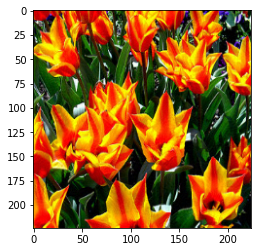

After adversaries
Predicted label: dandelion


In [32]:
# Let's see this in action
perturb_image(flower_model, sample_val_image, CLASSES.index(sample_val_image.split("/")[1]), 1)

## Adversarial training

In [33]:
# Setup Neural Structured Learning
!pip install -q neural-structured-learning
import neural_structured_learning as nsl

     |████████████████████████████████| 112kB 3.4MB/s 


Note: It's possible to also train a model with `NSL` using the `ImageDataGenerator` using the hack shown in [this thread](https://github.com/tensorflow/neural-structured-learning/issues/51). 

In [0]:
# NSL wouldn't support ImageDataGenerator, so,
# let's create NumPy arrays
def create_numpy_arrays(split):
    images = []
    labels = []

    # Gather the image paths and shuffle train paths
    all_paths = list(paths.list_images(split))
    if split == "train":
        random.shuffle(all_paths)

    # Iterate and process
    for image_path in tqdm(all_paths):
        image = plt.imread(image_path)
        label = image_path.split("/")[1]
        image = cv2.resize(image, (224, 224))
        image = image/255.

        images.append(image)
        labels.append(label)

    return (np.array(images), np.array(labels))

In [35]:
# And shoot!
X_train, y_train = create_numpy_arrays("train")
X_val, y_val = create_numpy_arrays("val")

100%|██████████| 550/550 [00:02<00:00, 238.54it/s]


In [0]:
# Verify the shapes
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((3120, 224, 224, 3), (3120,), (550, 224, 224, 3), (550,))

In [36]:
# One-hot encode
from sklearn.preprocessing import LabelEncoder

lb = LabelEncoder()
y_train_enc = lb.fit_transform(y_train)
y_val_enc = lb.transform(y_val)

y_train_ohe = tf.keras.utils.to_categorical(y_train_enc)
y_val_ohe = tf.keras.utils.to_categorical(y_val_enc)

y_train_ohe.shape, y_val_ohe.shape

((3120, 5), (550, 5))

In [0]:
# Create TensorFlow dataset
train_ds = (
    tf.data.Dataset
    .from_tensor_slices({"image": X_train, "label": y_train_ohe})
    .repeat()
    .batch(32)
    .prefetch(tf.data.experimental.AUTOTUNE)
)
val_ds = (
    tf.data.Dataset
    .from_tensor_slices({"image": X_val, "label": y_val_ohe})
    .repeat()
    .batch(32)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

- `adv_multiplier`: The weight of adversarial loss in the training objective, relative to the labeled loss.
- `adv_step_size`: The magnitude of adversarial perturbation.
- `adv_grad_norm`: The norm to measure the magnitude of adversarial perturbation.

In [0]:
# Configuration for adversarial training
adv_config = nsl.configs.make_adv_reg_config(
    multiplier=0.3,
    adv_step_size=0.1,
    adv_grad_norm="infinity"
)

In [0]:
def get_adv_training_model():
    # We are not training the extractor model
    EXTRACTOR.trainable = False
    # Construct the head of the model that will be placed on top of the
    # the base model
    class_head = EXTRACTOR.output
    class_head = GlobalAveragePooling2D()(class_head)
    class_head = Dense(512, activation="relu")(class_head)
    class_head = Dropout(0.5)(class_head)
    class_head = Dense(5, activation="softmax")(class_head)

    # Create the new model
    classifier = Model(inputs=EXTRACTOR.input, outputs=class_head)

    return classifier

In [40]:
# Create and compile the adv. model
base_adv_model = get_adv_training_model()
adv_model = nsl.keras.AdversarialRegularization(
    base_adv_model,
    adv_config=adv_config
)

adv_model.compile(loss="categorical_crossentropy", 
                          optimizer="adam",
                          metrics=["accuracy"])

# Train the model
start = time.time()
h = adv_model.fit(train_ds,
              steps_per_epoch=3120//32,
              validation_data=val_ds,
              validation_steps=550//32,
              epochs=10)
print("Total training time: ",time.time()-start)

Epoch 1/10

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

97/97 [==============================] - 39s 398ms/step - loss: 1.0540 - categorical_crossentropy: 0.5926 - categorical_accuracy: 0.7887 - adversarial_loss: 1.5381 - val_loss: 0.7323 - val_categorical_crossentropy: 0.3528 - val_categorical_accuracy: 0.8732 - val_adversarial_loss: 1.2651
Epoch 2/10
97/97 [==============================] - 36s 371ms/step - loss: 0.6931 - categorical_crossentropy: 0.3230 - categorical_accuracy: 0.8885 - adversarial_loss: 1.2338 - val_loss: 0.6577 - val_categoric

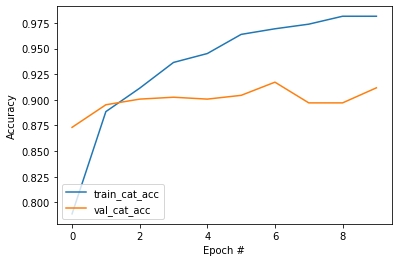

In [41]:
N = len(h.history["loss"])
plt.figure()
plt.plot(np.arange(0, N), h.history["categorical_accuracy"], label="train_cat_acc")
plt.plot(np.arange(0, N), h.history["val_categorical_accuracy"], label="val_cat_acc")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")
plt.show()

The accuracy of this model is not anywhere near our previous model's accuracy. Now, we will test the robustness of the above two models under adversarial perturbations as shown in [this tutorial](https://www.tensorflow.org/neural_structured_learning/tutorials/adversarial_keras_cnn_mnist#robustness_under_adversarial_perturbations). Most of the code below comes from that tutorial itself. 

In [0]:
# Compile the base model after wrapping it with `AdversarialRegularization`
# Needed to generate perturbated samples
reference_model = nsl.keras.AdversarialRegularization(
    flower_model,
    adv_config=adv_config)
reference_model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"])

In [0]:
# Models to be evaluated
models_to_eval = {
    'base': flower_model,
    'adv-regularized': adv_model.base_model
}
metrics = {
    name: tf.keras.metrics.CategoricalAccuracy()
    for name in models_to_eval.keys()
}

In [44]:
# Comes from the above-mentioned tutorial with some modification
perturbed_images, labels, predictions = [], [], []

val_ds = (
    tf.data.Dataset
    .from_tensor_slices({"image": X_val, "label": y_val_ohe})
    .batch(32)
)

for batch in val_ds:
    perturbed_batch = reference_model.perturb_on_batch(batch)
    # Clipping makes perturbed examples have the same range as regular ones.
    perturbed_batch["image"] = tf.clip_by_value(                          
        perturbed_batch["image"], 0.0, 1.0)
    y_true = perturbed_batch.pop("label")
    perturbed_images.append(perturbed_batch["image"].numpy())
    labels.append(y_true.numpy())
    predictions.append({})
    for name, model in models_to_eval.items():
        y_pred = model(perturbed_batch)
        metrics[name](y_true, y_pred)
        predictions[-1][name] = tf.argmax(y_pred, axis=-1).numpy()

for name, metric in metrics.items():
    print('%s model accuracy: %f' % (name, metric.result().numpy()))

base model accuracy: 0.316364
adv-regularized model accuracy: 0.718182


With more training the adversarial model's performance could be more improved. 

accuracy in batch 1:
base model: 13 / 32
adv-regularized model: 30 / 32


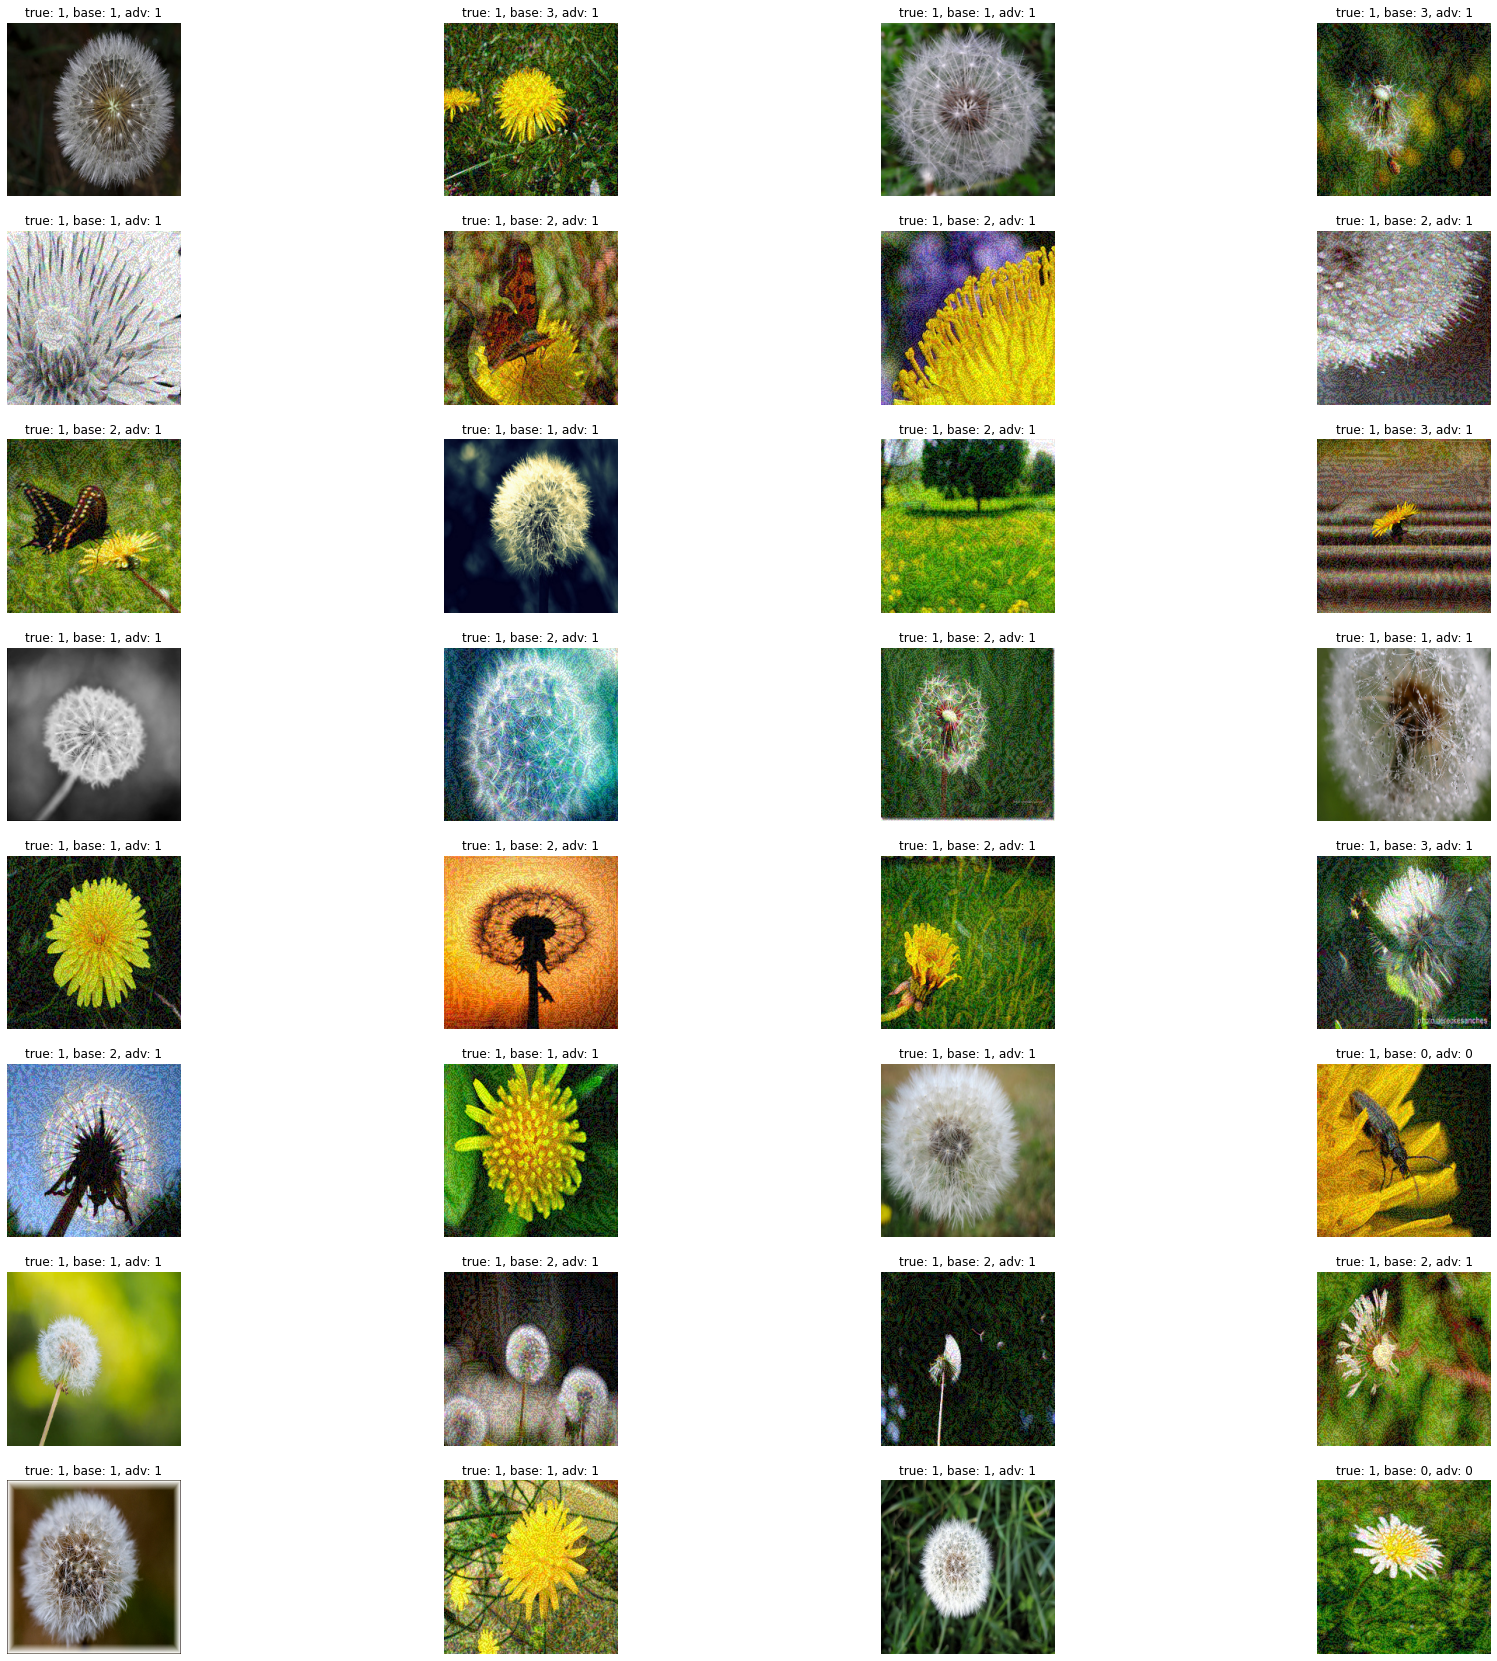

In [45]:
# Comes from the above-mentioned tutorial with some modification
batch_index = 1 # Change as needed

batch_image = perturbed_images[batch_index]
batch_label = labels[batch_index]
batch_pred = predictions[batch_index]

batch_size = 32
n_col = 4
n_row = (batch_size + n_col - 1) / n_col

print('accuracy in batch %d:' % batch_index)
for name, pred in batch_pred.items():
    print('%s model: %d / %d' % (name, np.sum(np.argmax(batch_label) == pred), batch_size))

plt.figure(figsize=(30, 30))
for i, (image, y) in enumerate(zip(batch_image, batch_label)):
    y_base = batch_pred['base'][i]
    y_adv = batch_pred['adv-regularized'][i]
    y = np.argmax(y)
    plt.subplot(n_row, n_col, i+1)
    plt.title('true: {}, base: {}, adv: {}'.format(y, y_base, y_adv))
    plt.imshow(tf.keras.preprocessing.image.array_to_img(image))
    plt.axis('off')

plt.show()

## To do:
- Play with the hyperparameters and see how far this can be pushed. 